# Задача классификации изображений

## Импорт библиотек

In [2]:
# Основные библиотеки
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms # по возможности отказаться в пользу v2
from torchvision.transforms import v2


In [16]:
# Вспомогательные библиотеки

import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

# для загрузки изображений
from PIL import Image 

# для отображения прогресс-бар при работе с циклами
from tqdm import tqdm

In [17]:
# Библиотеки для загрузки данных

import struct
import sys

from array import array
from os import path
from pathlib import Path

In [6]:
# выбор процессора

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Для данной задачи будет использован датасет **MNIST**.

## Трансформация MNIST в файловую структуру

In [19]:
#считываем данные в переменные

train_dataset = torchvision.datasets.MNIST(root='/content/sample_data/', train=True, download=True)
test_dataset = torchvision.datasets.MNIST(root='/content/sample_data/', train=False, download=True)

In [20]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/sample_data/
    Split: Train

**Формат MNIST файлов:**
 - t10k-images-idx3-ubyte - это ОДИН бинарный файл, который содержит ВСЕ 10,000 тестовых изображений
 - t10k-labels-idx1-ubyte - это ОДИН бинарный файл, который содержит ВСЕ 10,000 соответствующих меток

**Структура файлов:**
 - Для файла с изображениями:
   
     [магическое число] [количество изображений] [высота] [ширина]
   
     [пиксели изображения 1]
   
     [пиксели изображения 2]
   
     ...
   
     [пиксели изображения 10000]
   
 - Для файла с метками:
   
     [магическое число] [количество меток]

   
     [метка 1] [метка 2] ... [метка 10000]

**Магическое число нужно, так как это:**
 - Идентификация формата - программа может проверить, что это действительно MNIST файл
 - Защита от ошибок - если магическое число не совпадает, файл поврежден или имеет неверный формат
 - Определение endianness - порядок байтов (big-endian в случае MNIST)
     

In [21]:
len(train_dataset)

60000

In [22]:
train_dataset[2000]

(<PIL.Image.Image image mode=L size=28x28>, 5)

In [23]:
train_dataset[2000][0]

In [24]:
train_dataset[2000][1]

5

### Функция считывания данных MNIST
 - реализована так, чтобы все данные считывались разово, а не поэлементно
 - данные считываются в бинарном формате

In [25]:
def read_MNIST_ds(dataset):
    # Проверяем, какой датасет нужно загрузить - тренировочный или тестовый
    if dataset == "training":
        # Путь к файлу с изображениями тренировочного набора
        path_img = "/content/sample_data/MNIST/raw/train-images-idx3-ubyte"
        # Путь к файлу с метками тренировочного набора
        path_lbl = "/content/sample_data/MNIST/raw/train-labels-idx1-ubyte"
    
    elif dataset == "testing":
        # Путь к файлу с изображениями тестового набора
        path_img = "/content/sample_data/MNIST/raw/t10k-images-idx3-ubyte"
        # Путь к файлу с метками тестового набора
        path_lbl = "/content/sample_data/MNIST/raw/t10k-labels-idx1-ubyte"
    
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    # Открываем файл с метками для чтения в бинарном режиме
    with open(path_lbl, 'rb') as f_lable:
        # Читаем первые 8 байт и распаковываем их как два беззнаковых целых числа (big-endian)
        # Первое число - магическое число, второе - количество меток
        magic, lbl_size = struct.unpack(">II", f_lable.read(8))
        if magic != 2049:
            raise ValueError("Это не MNIST lables файл!")
        else:
            # Читаем оставшиеся байты файла и сохраняем как массив знаковых байтов
            lables_arr = array("b", f_lable.read())

    # Открываем файл с изображениями для чтения в бинарном режиме
    with open(path_img, 'rb') as f_img:
        # Читаем первые 16 байт и распаковываем как четыре беззнаковых целых числа (big-endian)
        # Магическое число, количество изображений, количество строк, количество столбцов
        magic, img_size, rows, cols = struct.unpack(">IIII", f_img.read(16))
        if magic != 2051:
            raise ValueError("Это не MNIST images файл!")
        else:
            # Читаем оставшиеся байты файла и сохраняем как массив беззнаковых байтов
            img_arr = array("B", f_img.read())

    if lbl_size == img_size:
        size = img_size
    else:
        print('Количество меток не соответствует количеству изображений')
        
    return lables_arr, img_arr, size, rows, cols

In [26]:
read_done = read_MNIST_ds('testing')

In [27]:
[type(i) for i in read_done]

[array.array, array.array, int, int, int]

In [28]:
print([i[:10] for i in read_done if isinstance(i, array)])

[array('b', [7, 2, 1, 0, 4, 1, 4, 9, 5, 9]), array('B', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]


### Преобразование MNIST-датасета из бинарного формата в отдельные JPEG файлы, организованные по папкам классов

In [29]:
def write_dataset(labels, data, size, rows, cols, output_dir):

    #-----------------------------------------------------# 
    #             Подготовка папок с классами             #
    #-----------------------------------------------------#
    
    # Словарь с именами папок для каждого класса (0-9)
    classes = {i: f"class_{i}" for i in range(10)}

    # Список путей к папкам для каждого класса
    #пример ...education\neural_networks_course\libs\pytorch\mnist_dataset\training\class_0

    output_dirs = [
        path.join(output_dir, classes[i])
        for i in range(10)
    ]
    
    # Сооздание папок, если они не существуют
    for dir in output_dirs:
            if not path.exists(dir):
                os.makedirs(dir)
                print(f"Создана папка: {dir}") 

    #-----------------------------------------------------# 
    # Запись данных - основной цикл по всем изображениям  #
    #-----------------------------------------------------#
    
    for (i, label) in enumerate(labels):
            # Имя файла: "/training/class_0/123.jpg"
            output_filename = path.join(output_dirs[label], str(i) + ".jpg")
            print("writing: " + output_filename)

            with open(output_filename, "wb") as h:
            # Извлекаем пиксели каждого изображения из большого массива
                data_i = [
                    data[ (i*rows*cols + j*cols) : (i*rows*cols + (j+1)*cols) ]
                    for j in range(rows)
                ]
                
             # Преобразует в numpy массив размером rows x cols
            data_array = np.asarray(data_i)
        
             # Создаем изображение из массива и сохраняет как JPEG с именем файла, сделанном в первом пункте цикла
            im = Image.fromarray(data_array)
            im.save(output_filename)

In [61]:
# Проверка, куда сохраняю файлы

output_path = os.path.abspath(os.path.join(os.getcwd(), '..', '_datasets\mnist'))
print("Папка будет создана здесь:", output_path)

Папка будет создана здесь: C:\Users\metel\education\neural_networks_course\_datasets\mnist


In [ ]:
# Обрабатывает оба датасета: тренировочный и тестовый
for dataset in ["training", "testing"]:
    write_dataset(*read_MNIST_ds(dataset), path.join(output_path, dataset))

## Создание своего класса для датасета MNIST
пользовательский класс с 3 методами:
- Конструктор
- Получение длины датасета
- Извлечение кортежа (образец, ответ)

In [14]:
# Наследование от класса Dataset из torch.utils.data

class MNIST_DS(Dataset):
    def __init__(self, path, transform=None):
        self.path = path             #переданный путь до папки класса
        self.transform = transform   #трансформация - будет использоваться дальше, т.е. вместо transform будут подставляться различные функции

        self.len_dataset = 0 # длина ds (кол-во файлов в указанной папке)
        self.data_list = []  # список из кортежей (путь до файла, позиция в one-hot векторе)
        self.class_to_index = {}

        for path_dir, dir_list, file_list in os.walk(path): # см. описание ниже
            if path_dir == path:
                self.classes = sorted(dir_list) # названия папок - это и есть классы, поэтому сохраняем в таком виде
                                        # создаем словарь {class_0: 0, class_1:1 ...}
                self.class_to_index = { 
                    cls_name: i for i, cls_name, in enumerate(self.classes)
                }
                continue #создали на уровне папок классов словарь, а то что дальше это уже следующая итерация os.walk(path) с файлами
                
            cls = path_dir.split('\\')[-1]

            for name_file in file_list:
                file_path = os.path.join(path_dir, name_file)
                self.data_list.append((file_path, self.class_to_index[cls]))

            self.len_dataset += len(file_list)        
                

    def __len__(self):
        return self.len_dataset

    
    def __getitem__ (self, index):
        file_path, target = self.data_list[index]
        # sample = np.array(Image.open(file_path)) # возвращает изображение в формате PIL (ф-ция из PIL-library)

        if self.transform is not None:           # если трансформации заданы, то применим их к изображению
            sample = Image.open(file_path)
            sample = self.transform(sample)
        else:
            sample = np.array(Image.open(file_path)) # возвращает изображение в формате PIL (ф-ция из PIL-library)

        return sample, target

**os.walk(path)**:

   это генератор, который рекурсивно обходит дерево каталогов и возвращает информацию о файлах и папках
- path - текущий путь
- dir_list - список поддиректорий
- file_list - список файлов

**Сбалансированность классов**

In [97]:
mnist_path = os.path.abspath(os.path.join(os.getcwd(), "..", "_datasets/mnist/training"))

In [101]:
sum_ = 0
for path, dir_list, file_list in os.walk(mnist_path):
    folder_name = path.split("\\")[-1]
    print(folder_name, end = '')
    print(f' - количество файлов: {len(file_list)}')
    sum_ += len(file_list)
print(f'\nВсего {sum_}')

training - количество файлов: 0
class_0 - количество файлов: 5923
class_1 - количество файлов: 6742
class_2 - количество файлов: 5958
class_3 - количество файлов: 6131
class_4 - количество файлов: 5842
class_5 - количество файлов: 5421
class_6 - количество файлов: 5918
class_7 - количество файлов: 6265
class_8 - количество файлов: 5851
class_9 - количество файлов: 5949

Всего 60000


#### Создание тренировочного и тестового датасетов

In [108]:
train_data = MNIST_DS(os.path.join(os.getcwd(), "..", "_datasets/mnist/training"))
test_data = MNIST_DS(os.path.join(os.getcwd(), "..", "_datasets/mnist/testing"))

In [109]:
train_data.classes

['class_0',
 'class_1',
 'class_2',
 'class_3',
 'class_4',
 'class_5',
 'class_6',
 'class_7',
 'class_8',
 'class_9']

In [110]:
train_data.class_to_index

{'class_0': 0,
 'class_1': 1,
 'class_2': 2,
 'class_3': 3,
 'class_4': 4,
 'class_5': 5,
 'class_6': 6,
 'class_7': 7,
 'class_8': 8,
 'class_9': 9}

In [111]:
train_data.len_dataset

60000

In [112]:
test_data.len_dataset

10000

In [113]:
# Представление в виде one-hot vector

for cls, one_hot_position in train_data.class_to_index.items():
    zero_mtx = np.zeros(10)
    zero_mtx[one_hot_position] = 1
    print(cls, ' => ',zero_mtx)

class_0  =>  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
class_1  =>  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
class_2  =>  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
class_3  =>  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
class_4  =>  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
class_5  =>  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
class_6  =>  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
class_7  =>  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
class_8  =>  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
class_9  =>  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [114]:
# Проверка метода len

print(f'Длина тренировочного датасета: {len(train_data)}')
print(f'Длина тестового датасета:      {len(test_data)}')

Длина тренировочного датасета: 60000
Длина тестового датасета:      10000


Класс - class_5


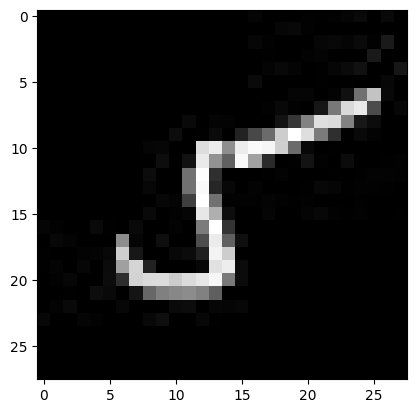

In [115]:
# Проверка метода getitem
# index: 0 ... 59999

img, target_class = train_data[32641]

print(f'Класс - {train_data.classes[target_class]}')
plt.imshow(img, cmap = 'gray')

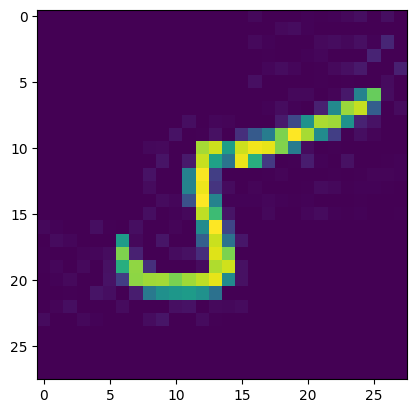

In [116]:
plt.imshow(img)

#### Обучающая, Валидационная и Тестовая выборки

In [117]:
# Разбиение на выборки

train_data, val_data = random_split(train_data, [0.8, 0.2])

In [118]:
print(f'Длина тренировочных данных: {len(train_data)}')
print(f'Длина валидационных данных: {len(val_data)}')
print(f'Длина тестового данных:     {len(test_data)}')

Длина тренировочных данных: 48000
Длина валидационных данных: 12000
Длина тестового данных:     10000


In [119]:
# Разбиение на батчи

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

In [120]:
for i, (samples, target) in enumerate(train_loader):
     if i < 3:
         print(f"Номер batch = {i+1}")
         print(f"    размер samples = {samples.shape}")
         print(f"    размер target = {target.shape}")

print('\n ...... \n')
print(f"Номер batch = {i+1}")
print(f"    размер samples = {samples.shape}")
print(f"    размер target = {target.shape}")

Номер batch = 1
    размер samples = torch.Size([16, 28, 28])
    размер target = torch.Size([16])
Номер batch = 2
    размер samples = torch.Size([16, 28, 28])
    размер target = torch.Size([16])
Номер batch = 3
    размер samples = torch.Size([16, 28, 28])
    размер target = torch.Size([16])

 ...... 

Номер batch = 3000
    размер samples = torch.Size([16, 28, 28])
    размер target = torch.Size([16])


### Применение трансформаций

In [12]:
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(dtype = torch.float32, scale=True),
        v2.Normalize(mean=(0.5,), std = (0.5,))
    ]
)                            

In [18]:
mnist_train_data_obj = MNIST_DS(os.path.join(os.getcwd(), "..", "_datasets/mnist/training"), transform=transform)
mnist_test_data = MNIST_DS(os.path.join(os.getcwd(), "..", "_datasets/mnist/testing"), transform=transform)

In [19]:
mnist_img, mnist_class = mnist_test_data[3187]

print(f'\033[94mimg:\033[0m')
print(f'   {type(mnist_img)}')
print(f'   {mnist_img.shape}')
print(f'   {mnist_img.dtype}')
print(f'   min = {mnist_img.min()}, max = {mnist_img.max()}')
print(f'\033[94mclass:\033[0m')
print(f'   {mnist_class}')

img:
   <class 'torchvision.tv_tensors._image.Image'>
   torch.Size([1, 28, 28])
   torch.float32
   min = -1.0, max = 1.0
class:
   3


In [20]:
# Разбиение на выборки
mnist_train_data, mnist_val_data = random_split(mnist_train_data_obj, [0.8, 0.2])

In [21]:
# Разбиение на батчи

mnist_train_loader = DataLoader(mnist_train_data, batch_size=16, shuffle=True)
mnist_val_loader = DataLoader(mnist_val_data, batch_size=16, shuffle=False)
mnist_test_loader = DataLoader(mnist_test_data, batch_size=16, shuffle=False)

In [127]:
mnist_imgs, mnist_classes = next(iter(mnist_train_loader))

print(f'\033[94mimg:\033[0m')
print(f'   {type(mnist_imgs)}')
print(f'   {mnist_imgs.shape}')
print(f'   {mnist_imgs.dtype}')

print(f'\033[94mclass:\033[0m')
print(f'   {type(mnist_classes)}')
print(f'   {mnist_classes.shape}')
print(f'   {mnist_classes.dtype}')
print(f'\n   {mnist_classes}')


img:
   <class 'torch.Tensor'>
   torch.Size([16, 1, 28, 28])
   torch.float32
class:
   <class 'torch.Tensor'>
   torch.Size([16])
   torch.int64

   tensor([3, 8, 3, 7, 2, 4, 9, 1, 4, 5, 2, 6, 8, 3, 4, 6])


## Создание модели для классификации MNIST

In [4]:
class MnistModel(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.layer_1 = nn.Linear(input, 128)
        self.layer_2 = nn.Linear(128, output)
        self.dropout = nn.Dropout(0.5)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.layer_1(x)
        x = self.act(x)
        x = self.dropout(x)
        out = self.layer_2(x)

        return out

In [7]:
model_classification = MnistModel(784, 10).to(device)

In [136]:
# проверка правильности построения модели при помощи рандомного тензора

check_input = torch.rand([16,784], dtype = torch.float32).to(device)
check_output = model_classification(check_input)
check_output.shape

torch.Size([16, 10])

## Тренировка модели

In [23]:
# Определяем функцию потерь и оптимизатор градиентного спуска

loss_classification = nn.CrossEntropyLoss()
opt_classification = torch.optim.Adam(model_classification.parameters(), lr=0.001)

In [138]:
mnist_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                            opt_classification,   # оптимизатор
                            mode='min',           # 'max' или 'min'
                            factor=0.1,           # коэффициент, на который будет умножен lr
                            patience=5            # кол-во эпох без улучшения отслеживаемого параметра
                        )

In [139]:
EPOCHS = 60

train_loss = []
val_loss = []
train_acc = []
val_acc = []
mnist_lr_list = []
best_loss = None
count = 0
last_saved_mnist_model = ''

for epoch in range(EPOCHS):

    #режим тренировки
    model_classification.train()
    running_train_loss = []
    train_true_answers = 0
    train_loop = tqdm(mnist_train_loader, leave=False)
    for x, targets in train_loop:
        # (batch_size, 1, 28, 28) -> (batch_size, 728)
        x = x.reshape(-1, 28*28).to(device)
        # (batch_size, int) -> (batch_size, 10)
        targets = targets.reshape(-1).to(torch.int32)
        targets = torch.eye(10)[targets].to(device)


        # прямой проход + расчет ошибки модели
        pred = model_classification(x)
        # pred - ответ модели,  target - правильные ответы -> подаем на вход ф-ции потерь
        loss = loss_classification(pred, targets)

        # обратный проход
        opt_classification.zero_grad() #обнуляем градиенты для каждого батча
        loss.backward() # рассчитываем градиенты для текущего батча

        # шаг оптимизации
        opt_classification.step() # Используем градиенты из шага выше для обновления весов

        running_train_loss.append(loss.item())
        mean_train_loss = sum(running_train_loss)/len(running_train_loss)

        train_true_answers += (targets.argmax(dim=1) == pred.argmax(dim=1)).sum().item()

        train_loop.set_description(f'Epoch: [{epoch+1}/{EPOCHS}], train_loss = {mean_train_loss:.4f}') 

    # Расчет метрик
    train_accuracy = train_true_answers/len(mnist_train_data)
    
    # Сохранение значений функции потерь
    train_loss.append(mean_train_loss)
    train_acc.append(train_accuracy)
    

    #режим оценки
    model_classification.eval()
    with torch.no_grad():
        running_val_loss = []
        val_true_answers = 0
        val_loop = tqdm(mnist_val_loader, leave=False)
        for x, targets in val_loop:
            # (batch_size, 1, 28, 28) -> (batch_size, 728)
            x = x.reshape(-1, 28*28).to(device)
            # (batch_size, int) -> (batch_size, 10)
            targets = targets.reshape(-1).to(torch.int32)
            targets = torch.eye(10)[targets].to(device)

            # прямой проход + расчет ошибки модели
            pred = model_classification(x)
            # pred - ответ модели,  target - правильные ответы -> подаем на вход ф-ции потерь
            loss = loss_classification(pred, targets)


            running_val_loss.append(loss.item())
            mean_val_loss = sum(running_val_loss)/len(running_val_loss)

            val_loop.set_description(f'Epoch: [{epoch+1}/{EPOCHS}], train_loss = {mean_val_loss:.4f}') 

            val_true_answers += (pred.argmax(dim=1) == targets.argmax(dim=1)).sum().item()

        # Расчет метрик
        val_accuracy = val_true_answers / len(mnist_val_data)
        
    # Сохранение значений функции потерь
    val_loss.append(mean_val_loss)
    val_acc.append(val_accuracy)

    mnist_lr_scheduler.step(mean_val_loss)
    lr = mnist_lr_scheduler.get_last_lr()[0]
    mnist_lr_list.append(lr)
        

    print(f'Epoch: [{epoch+1}/{EPOCHS}], train_loss = {mean_train_loss:.4f}, train_acc={train_accuracy:.4f}, val_loss={mean_val_loss:.4f}, val_acc={val_accuracy:.4f}')

    if best_loss is None:
        best_loss = mean_val_loss

    if mean_val_loss < best_loss:
        best_loss = mean_val_loss
        count = 0

        checkpoint = {
                        'class_to_index': mnist_train_data_obj.class_to_index,
                        'state_model': model_classification.state_dict(),     # веса модели
                        'state_opt': opt_classification.state_dict(),             # состояние оптимизатора
                        'state_lr_scheduler': mnist_lr_scheduler.state_dict(),  # состояние scheduler
                        'loss': {                                  # метрики потерь
                            'train_loss': train_loss,
                            'val_loss': val_loss,
                            'best_loss': best_loss
                        },
                        'metric': {                                # метрики accuracy
                            'train_acc': train_acc,
                            'val_acc': val_acc,
                        },
                        'lr': mnist_lr_list,                         # история learning rate
                        'epoch': {                                 # информация об эпохах
                            'EPOCHS': EPOCHS,
                            'save_epoch': epoch
                        }
                    }

        if os.path.exists(last_saved_mnist_model):
            os.remove(last_saved_mnist_model)
        last_saved_mnist_model = f'models/mnist_model_checkpoint_epoch_{epoch+1}.pt'
        torch.save(checkpoint, last_saved_mnist_model)
        print(f'На эпохе = {epoch+1} сохранена модель {last_saved_mnist_model}. Функция потерь на валидации: {mean_val_loss:.4f}', end='\n\n')
    
    if count >= 10:
        print(f'\033[31mОбучение остановлено на {epoch + 1} эпохе.\033[0m')
        break

    count += 1


        

Epoch: [1/60], train_loss = 0.5586, train_acc=0.8248, val_loss=0.2611, val_acc=0.9194


Epoch: [2/60], train_loss = 0.3961, train_acc=0.8784, val_loss=0.2279, val_acc=0.9331
На эпохе = 2 сохранена модель models/mnist_model_checkpoint_epoch_2.pt. Функция потерь на валидации: 0.2279



Epoch: [3/60], train_loss = 0.3555, train_acc=0.8888, val_loss=0.2081, val_acc=0.9388
На эпохе = 3 сохранена модель models/mnist_model_checkpoint_epoch_3.pt. Функция потерь на валидации: 0.2081



Epoch: [4/60], train_loss = 0.3282, train_acc=0.8986, val_loss=0.1817, val_acc=0.9493
На эпохе = 4 сохранена модель models/mnist_model_checkpoint_epoch_4.pt. Функция потерь на валидации: 0.1817



Epoch: [5/60], train_loss = 0.3180, train_acc=0.8995, val_loss=0.1739, val_acc=0.9507
На эпохе = 5 сохранена модель models/mnist_model_checkpoint_epoch_5.pt. Функция потерь на валидации: 0.1739



Epoch: [6/60], train_loss = 0.3043, train_acc=0.9046, val_loss=0.1613, val_acc=0.9539
На эпохе = 6 сохранена модель models/mnist_model_checkpoint_epoch_6.pt. Функция потерь на валидации: 0.1613



Epoch: [7/60], train_loss = 0.2948, train_acc=0.9091, val_loss=0.1710, val_acc=0.9537


Epoch: [8/60], train_loss = 0.2871, train_acc=0.9110, val_loss=0.1682, val_acc=0.9527


Epoch: [9/60], train_loss = 0.2803, train_acc=0.9109, val_loss=0.1698, val_acc=0.9518


Epoch: [10/60], train_loss = 0.2706, train_acc=0.9146, val_loss=0.1567, val_acc=0.9563
На эпохе = 10 сохранена модель models/mnist_model_checkpoint_epoch_10.pt. Функция потерь на валидации: 0.1567



Epoch: [11/60], train_loss = 0.2722, train_acc=0.9155, val_loss=0.1561, val_acc=0.9579
На эпохе = 11 сохранена модель models/mnist_model_checkpoint_epoch_11.pt. Функция потерь на валидации: 0.1561



Epoch: [12/60], train_loss = 0.2661, train_acc=0.9163, val_loss=0.1601, val_acc=0.9566


Epoch: [13/60], train_loss = 0.2611, train_acc=0.9171, val_loss=0.1551, val_acc=0.9573
На эпохе = 13 сохранена модель models/mnist_model_checkpoint_epoch_13.pt. Функция потерь на валидации: 0.1551



Epoch: [14/60], train_loss = 0.2590, train_acc=0.9179, val_loss=0.1568, val_acc=0.9582


Epoch: [15/60], train_loss = 0.2542, train_acc=0.9200, val_loss=0.1576, val_acc=0.9573


Epoch: [16/60], train_loss = 0.2548, train_acc=0.9204, val_loss=0.1656, val_acc=0.9559


Epoch: [17/60], train_loss = 0.2488, train_acc=0.9200, val_loss=0.1587, val_acc=0.9573


Epoch: [18/60], train_loss = 0.2480, train_acc=0.9215, val_loss=0.1548, val_acc=0.9602
На эпохе = 18 сохранена модель models/mnist_model_checkpoint_epoch_18.pt. Функция потерь на валидации: 0.1548



Epoch: [19/60], train_loss = 0.2458, train_acc=0.9203, val_loss=0.1543, val_acc=0.9588
На эпохе = 19 сохранена модель models/mnist_model_checkpoint_epoch_19.pt. Функция потерь на валидации: 0.1543



Epoch: [20/60], train_loss = 0.2407, train_acc=0.9238, val_loss=0.1572, val_acc=0.9584


Epoch: [21/60], train_loss = 0.2359, train_acc=0.9250, val_loss=0.1660, val_acc=0.9572


Epoch: [22/60], train_loss = 0.2378, train_acc=0.9250, val_loss=0.1574, val_acc=0.9587


Epoch: [23/60], train_loss = 0.2371, train_acc=0.9246, val_loss=0.1484, val_acc=0.9637
На эпохе = 23 сохранена модель models/mnist_model_checkpoint_epoch_23.pt. Функция потерь на валидации: 0.1484



Epoch: [24/60], train_loss = 0.2298, train_acc=0.9261, val_loss=0.1674, val_acc=0.9577


Epoch: [25/60], train_loss = 0.2366, train_acc=0.9252, val_loss=0.1543, val_acc=0.9604


Epoch: [26/60], train_loss = 0.2303, train_acc=0.9263, val_loss=0.1643, val_acc=0.9575


Epoch: [27/60], train_loss = 0.2353, train_acc=0.9261, val_loss=0.1442, val_acc=0.9646
На эпохе = 27 сохранена модель models/mnist_model_checkpoint_epoch_27.pt. Функция потерь на валидации: 0.1442



Epoch: [28/60], train_loss = 0.2283, train_acc=0.9280, val_loss=0.1604, val_acc=0.9585


Epoch: [29/60], train_loss = 0.2289, train_acc=0.9275, val_loss=0.1597, val_acc=0.9608


Epoch: [30/60], train_loss = 0.2278, train_acc=0.9278, val_loss=0.1499, val_acc=0.9626


Epoch: [31/60], train_loss = 0.2254, train_acc=0.9281, val_loss=0.1617, val_acc=0.9628


Epoch: [32/60], train_loss = 0.2214, train_acc=0.9297, val_loss=0.1560, val_acc=0.9606


Epoch: [33/60], train_loss = 0.2267, train_acc=0.9275, val_loss=0.1502, val_acc=0.9622


Epoch: [34/60], train_loss = 0.1715, train_acc=0.9455, val_loss=0.1384, val_acc=0.9682
На эпохе = 34 сохранена модель models/mnist_model_checkpoint_epoch_34.pt. Функция потерь на валидации: 0.1384



Epoch: [35/60], train_loss = 0.1596, train_acc=0.9489, val_loss=0.1367, val_acc=0.9680
На эпохе = 35 сохранена модель models/mnist_model_checkpoint_epoch_35.pt. Функция потерь на валидации: 0.1367



Epoch: [36/60], train_loss = 0.1593, train_acc=0.9489, val_loss=0.1369, val_acc=0.9685


Epoch: [37/60], train_loss = 0.1506, train_acc=0.9515, val_loss=0.1349, val_acc=0.9687
На эпохе = 37 сохранена модель models/mnist_model_checkpoint_epoch_37.pt. Функция потерь на валидации: 0.1349



Epoch: [38/60], train_loss = 0.1567, train_acc=0.9499, val_loss=0.1362, val_acc=0.9680


Epoch: [39/60], train_loss = 0.1507, train_acc=0.9510, val_loss=0.1359, val_acc=0.9683


Epoch: [40/60], train_loss = 0.1495, train_acc=0.9514, val_loss=0.1381, val_acc=0.9682


Epoch: [41/60], train_loss = 0.1492, train_acc=0.9515, val_loss=0.1367, val_acc=0.9681


Epoch: [42/60], train_loss = 0.1489, train_acc=0.9520, val_loss=0.1354, val_acc=0.9675


Epoch: [43/60], train_loss = 0.1489, train_acc=0.9525, val_loss=0.1351, val_acc=0.9686


Epoch: [44/60], train_loss = 0.1467, train_acc=0.9522, val_loss=0.1351, val_acc=0.9688


Epoch: [45/60], train_loss = 0.1499, train_acc=0.9521, val_loss=0.1348, val_acc=0.9688
На эпохе = 45 сохранена модель models/mnist_model_checkpoint_epoch_45.pt. Функция потерь на валидации: 0.1348



Epoch: [46/60], train_loss = 0.1436, train_acc=0.9534, val_loss=0.1347, val_acc=0.9683
На эпохе = 46 сохранена модель models/mnist_model_checkpoint_epoch_46.pt. Функция потерь на валидации: 0.1347



Epoch: [47/60], train_loss = 0.1426, train_acc=0.9533, val_loss=0.1356, val_acc=0.9684


Epoch: [48/60], train_loss = 0.1449, train_acc=0.9525, val_loss=0.1352, val_acc=0.9690


Epoch: [49/60], train_loss = 0.1434, train_acc=0.9540, val_loss=0.1352, val_acc=0.9686


Epoch: [50/60], train_loss = 0.1446, train_acc=0.9526, val_loss=0.1349, val_acc=0.9682


Epoch: [51/60], train_loss = 0.1431, train_acc=0.9533, val_loss=0.1347, val_acc=0.9687


Epoch: [52/60], train_loss = 0.1439, train_acc=0.9541, val_loss=0.1349, val_acc=0.9688


Epoch: [53/60], train_loss = 0.1430, train_acc=0.9528, val_loss=0.1349, val_acc=0.9690


Epoch: [54/60], train_loss = 0.1425, train_acc=0.9536, val_loss=0.1349, val_acc=0.9688


Epoch: [55/60], train_loss = 0.1420, train_acc=0.9540, val_loss=0.1348, val_acc=0.9688


Epoch: [56/60], train_loss = 0.1401, train_acc=0.9541, val_loss=0.1348, val_acc=0.9688
Обучение остановлено на 56 эпохе.


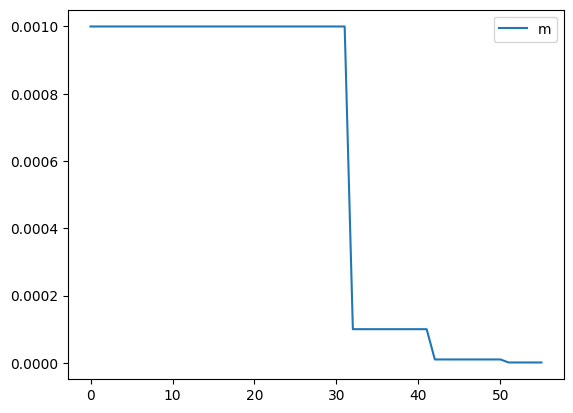

In [140]:
plt.plot(mnist_lr_list)
plt.legend('mnist_lr_list')
plt.show()

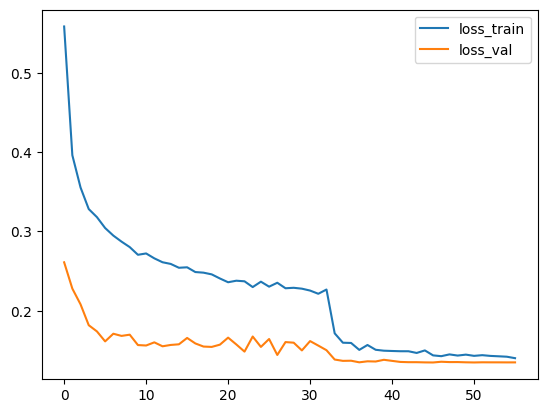

In [141]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['loss_train', 'loss_val'])
plt.show()

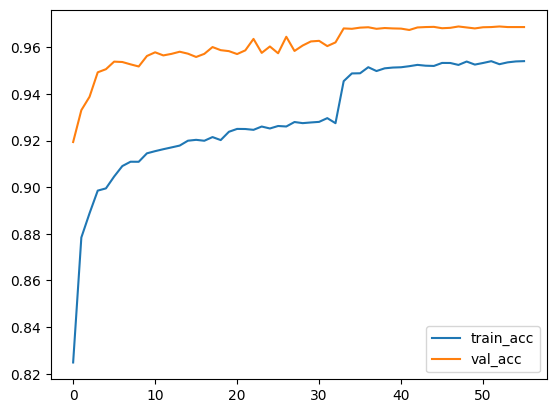

In [142]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['train_acc', 'val_acc'])
plt.show()

## Проверка модели

In [8]:
checkpoint = torch.load('models/mnist_model_checkpoint_epoch_46.pt')
model_classification.load_state_dict(checkpoint['state_model'])

<All keys matched successfully>

In [24]:
model_classification.eval()
with torch.no_grad():
        running_test_loss = []
        test_true_answers = 0
        for x, targets in mnist_test_loader:
            x = x.reshape(-1, 28*28).to(device)
            targets = targets.reshape(-1).to(torch.int32)
            targets = torch.eye(10)[targets].to(device)

            # прямой проход + расчет ошибки модели
            pred = model_classification(x)
            loss = loss_classification(pred, targets)

            running_test_loss.append(loss.item())
            mean_test_loss = sum(running_test_loss)/len(running_test_loss)
            
            test_true_answers += (pred.argmax(dim=1) == targets.argmax(dim=1)).sum().item()

        # Расчет метрик
        running_test_acc = test_true_answers / len(mnist_test_data)

print(f'test_loss = {mean_test_loss:.4f}, test_acc={running_test_acc:.4f}', end = '\n\n')

test_loss = 0.1180, test_acc=0.9719



## P.S. Вариант создания датасетов с исполльзованием встроенного класса ImageFolder

#### Создание трансформаций

In [148]:
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.Grayscale(), # эта трансформация нужна, чтобы сделать один цветовой канал как в нашем датасете
        v2.ToDtype(dtype = torch.float32, scale=True),
        v2.Normalize(mean=(0.5,), std = (0.5,))
    ]
)                            

#### Создание тренировочного и тестового датасетов

In [151]:
imf_train_data = ImageFolder(root = os.path.join(os.getcwd(), "..", "_datasets/mnist/training"), transform=transform)
imf_test_data = ImageFolder(root = os.path.join(os.getcwd(), "..", "_datasets/mnist/testing"), transform=transform)                        

In [152]:
imf_train_data.classes

['class_0',
 'class_1',
 'class_2',
 'class_3',
 'class_4',
 'class_5',
 'class_6',
 'class_7',
 'class_8',
 'class_9']

In [153]:
imf_train_data.class_to_idx

{'class_0': 0,
 'class_1': 1,
 'class_2': 2,
 'class_3': 3,
 'class_4': 4,
 'class_5': 5,
 'class_6': 6,
 'class_7': 7,
 'class_8': 8,
 'class_9': 9}

In [154]:
# Проверка метода len

print(f'Длина тренировочного датасета: {len(imf_train_data)}')
print(f'Длина тестового датасета:      {len(imf_test_data)}')

Длина тренировочного датасета: 60000
Длина тестового датасета:      10000


In [ ]:
 imf_train_data[32641]

Класс - class_5


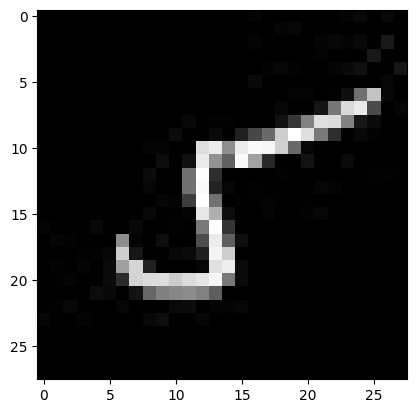

In [156]:
# Проверка метода getitem
# index: 0 ... 59999

imf_img, target_class = imf_train_data[32641]

print(f'Класс - {imf_train_data.classes[target_class]}')
plt.imshow(imf_img.squeeze().numpy(), cmap = 'gray')

#### Обучающая, Валидационная и Тестовая выборки

In [157]:
# Разбиение на выборки

imf_train_data, imf_val_data = random_split(imf_train_data, [0.8, 0.2])

In [158]:
print(f'Длина тренировочных данных: {len(imf_train_data)}')
print(f'Длина валидационных данных: {len(imf_val_data)}')
print(f'Длина тестового данных:     {len(imf_test_data)}')

Длина тренировочных данных: 48000
Длина валидационных данных: 12000
Длина тестового данных:     10000


In [159]:
# Разбиение на батчи

imf_train_loader = DataLoader(imf_train_data, batch_size=16, shuffle=True)
imf_val_loader = DataLoader(imf_val_data, batch_size=16, shuffle=False)
imf_test_loader = DataLoader(imf_test_data, batch_size=16, shuffle=False)

In [160]:
imf_imgs, imf_classes = next(iter(imf_train_loader))

print(f'\033[94mimg:\033[0m')
print(f'   {type(imf_imgs)}')
print(f'   {imf_imgs.shape}')
print(f'   {imf_imgs.dtype}')

print(f'\033[94mclass:\033[0m')
print(f'   {type(imf_classes)}')
print(f'   {imf_classes.shape}')
print(f'   {imf_classes.dtype}')
print(f'\n   {imf_classes}')

img:
   <class 'torch.Tensor'>
   torch.Size([16, 1, 28, 28])
   torch.float32
class:
   <class 'torch.Tensor'>
   torch.Size([16])
   torch.int64

   tensor([7, 8, 8, 9, 0, 6, 3, 7, 4, 1, 9, 2, 0, 0, 0, 0])


## Вывод

**Результаты обучения модели классификации MNIST:**

✅ **Модель успешно обучена за 46 эпох** (из 60 запланированных) с применением ранней остановки.

📊 **Метрики качества:**
- **Точность на тестовой выборке:** 97.19% (`test_acc=0.9719`)
- **Ошибка на тестовой выборке:** 0.1180 (`test_loss=0.1180`)

🛠 **Параметры обучения:**
- **Архитектура:** Полносвязная нейронная сеть (PyTorch)
- **Функция потерь:** `CrossEntropyLoss`
- **Оптимизатор:** Adam с начальным learning rate 0.001
- **Планировщик LR:** `ReduceLROnPlateau` (уменьшает LR в 10 раз при отсутствии улучшений 5 эпох)
- **Ранняя остановка:** сработала на 10-й эпохе без улучшений

💾 **Лучшая модель сохранена на 46-й эпохе** с учетом:
- Весов модели и оптимизатора
- Гиперпараметров и истории learning rate
- Метрик обучения и валидации

**Вывод:** Модель достигла высокой точности классификации (>97%) на MNIST с эффективным использованием регуляризации через раннюю остановку и адаптивную настройку learning rate.